# SMAC: Sequential Model Algorithm Configuration

This notebook shows how to use SMAC (v2.0.0a1) to optimize hyperparameters.
We refer to the [documentation](https://automl.github.io/SMAC3/development-2.0/) for more examples and details.

Note: After executing the first block, you need to reload your browser!

In [ ]:
# We basically install a new ipykernel
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

print("\nPlease reload the browser to activate Python 3.8.")

In [ ]:
# Check if we have the right python version
import sys
assert sys.version_info.major == 3
assert sys.version_info.minor == 8

# Now we install SMAC
!apt-get install swig
!pip install matplotlib
!pip install git+https://github.com/automl/SMAC3.git@development-2.0#egg=smac
# !pip install smac==2.0.0a1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Minimal Example

The example optimizes a support vector machine on the iris dataset.

In [ ]:
from ConfigSpace import Configuration, ConfigurationSpace

import numpy as np
from smac import Scenario
from smac import HyperparameterOptimizationFacade as HPOFacade
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

iris = datasets.load_iris()


def train(config: Configuration, seed: int = 0) -> float:
    classifier = SVC(C=config["C"], random_state=seed)
    scores = cross_val_score(classifier, iris.data, iris.target, cv=5)
    return 1 - np.mean(scores)


if __name__ == "__main__":
    configspace = ConfigurationSpace({"C": (0.1, 1000.0)})

    # Scenario object specifying the optimization environment
    scenario = Scenario(
        configspace,
        deterministic=True,  # Use only one seed
        n_trials=200,  # We try 200 different C values
    )

    # Use SMAC to find the best configuration/hyperparameters
    smac = HPOFacade(scenario, train, overwrite=True)
    incumbent = smac.optimize()

[INFO][abstract_initial_design.py:133] Using 10 initial design and 0 additional configurations.
[INFO][intensifier.py:275] No incumbent provided in the first run. Sampling a new challenger...
[INFO][intensifier.py:446] First run and no incumbent provided. Challenger is assumed to be the incumbent.
[INFO][intensifier.py:566] Updated estimated cost of incumbent on 1 trials: 0.04
[INFO][abstract_intensifier.py:340] Challenger (0.0333) is better than incumbent (0.04) on 1 trials.
[INFO][abstract_intensifier.py:364] Changes in incumbent:
[INFO][abstract_intensifier.py:367] --- C: 266.95183321777733 -> 716.1157102249563
[INFO][abstract_intensifier.py:340] Challenger (0.0267) is better than incumbent (0.0333) on 1 trials.
[INFO][abstract_intensifier.py:364] Changes in incumbent:
[INFO][abstract_intensifier.py:367] --- C: 716.1157102249563 -> 98.85349361812695
[INFO][abstract_intensifier.py:340] Challenger (0.0133) is better than incumbent (0.0267) on 1 trials.
[INFO][abstract_intensifier.py:3

## Multi-Fidelity Optimization

An example for optimizing a Multi-Layer Perceptron (MLP) using multiple budgets/fidelities. Since we want to take advantage of Multi-Fidelity, the ``MultiFidelityFacade`` is a good choice. By default,
``MultiFidelityFacade`` internally runs with [Hyperband](https://arxiv.org/abs/1603.06560) as intensification, which is a combination of an aggressive racing mechanism and successive halving. Crucially, the target function function
must accept a budget variable, detailing how much fidelity smac wants to allocate to this configuration.

MLP is a deep neural network, and therefore, we choose epochs as fidelity type. This implies that ``budget`` specifies the number of epochs smac wants to allocate. The digits dataset is chosen to optimize the average accuracy on 5-fold cross validation.

In [ ]:
import warnings

import numpy as np
from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    EqualsCondition,
    Float,
    InCondition,
    Integer,
)
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier

from smac import MultiFidelityFacade, Scenario


digits = load_digits()


class MLP:
    @property
    def configspace(self) -> ConfigurationSpace:
        # Build Configuration Space which defines all parameters and their ranges.
        # To illustrate different parameter types, we use continuous, integer and categorical parameters.
        cs = ConfigurationSpace()

        n_layer = Integer("n_layer", (1, 5), default=1)
        n_neurons = Integer("n_neurons", (8, 256), log=True, default=10)
        activation = Categorical("activation", ["logistic", "tanh", "relu"], default="tanh")
        solver = Categorical("solver", ["lbfgs", "sgd", "adam"], default="adam")
        batch_size = Integer("batch_size", (30, 300), default=200)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        learning_rate_init = Float("learning_rate_init", (0.0001, 1.0), default=0.001, log=True)

        # Add all hyperparameters at once:
        cs.add_hyperparameters([n_layer, n_neurons, activation, solver, batch_size, learning_rate, learning_rate_init])

        # Adding conditions to restrict the hyperparameter space...
        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        use_lr_init = InCondition(child=learning_rate_init, parent=solver, values=["sgd", "adam"])
        use_batch_size = InCondition(child=batch_size, parent=solver, values=["sgd", "adam"])

        # We can also add multiple conditions on hyperparameters at once:
        cs.add_conditions([use_lr, use_batch_size, use_lr_init])

        return cs

    def train(self, config: Configuration, seed: int = 0, budget: int = 25) -> float:
        # For deactivated parameters (by virtue of the conditions),
        # the configuration stores None-values.
        # This is not accepted by the MLP, so we replace them with placeholder values.
        lr = config["learning_rate"] if config["learning_rate"] else "constant"
        lr_init = config["learning_rate_init"] if config["learning_rate_init"] else 0.001
        batch_size = config["batch_size"] if config["batch_size"] else 200

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            classifier = MLPClassifier(
                hidden_layer_sizes=[config["n_neurons"]] * config["n_layer"],
                solver=config["solver"],
                batch_size=batch_size,
                activation=config["activation"],
                learning_rate=lr,
                learning_rate_init=lr_init,
                max_iter=int(np.ceil(budget)),
                random_state=seed,
            )

            # Returns the 5-fold cross validation accuracy
            cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)  # to make CV splits consistent
            score = cross_val_score(classifier, digits.data, digits.target, cv=cv, error_score="raise")

        return 1 - np.mean(score)


if __name__ == "__main__":
    mlp = MLP()

    # Define our environment variables
    scenario = Scenario(
        mlp.configspace,
        walltime_limit=60,  # After 60 seconds, we stop the hyperparameter optimization
        n_trials=200,  # Evaluate max 200 different trials
        min_budget=5,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
        max_budget=25,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
        n_workers=1,  # You can use multiple workers for multi-fidelity
    )

    # We want to run five random configurations before starting the optimization.
    initial_design = MultiFidelityFacade.get_initial_design(scenario, n_configs=5)

    # Create our SMAC object and pass the scenario and the train method
    smac = MultiFidelityFacade(
        scenario,
        mlp.train,
        initial_design=initial_design,
        overwrite=True,
    )

    # Let's optimize
    incumbent = smac.optimize()

    # Get cost of default configuration
    default_cost = smac.validate(mlp.configspace.get_default_configuration())
    print(f"Default cost: {default_cost}")

    # Let's calculate the cost of the incumbent
    incumbent_cost = smac.validate(incumbent)
    print(f"Incumbent cost: {incumbent_cost}")


[INFO][abstract_initial_design.py:68] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[WARNING][successive_halving.py:123] The target function is specified to be non-deterministic, but number of seeds to evaluate are set to 1. Consider increasing `n_seeds` from the intensifier.
[INFO][successive_halving.py:197] Using successive halving with budget type BUDGETS, min budget 5, max budget 25 and eta 3.
[INFO][abstract_initial_design.py:133] Using 5 initial design and 0 additional configurations.
[WARNING][abstract_parallel_intensifier.py:93] Hyperband is executed with 1 worker(s) only. However, your system supports up to 2 workers. Consider increasing the workers in the scenario.
[INFO][hyperband_worker.py:165] Finished Hyperband iteration-step 1-1 with initial budget 8.
[INFO][successive_halving_worker.py:396] First run and no incumbent provided. Challenger is assumed to be the incumbent.
[INFO][successive_halving_worker.py:613] Challenger (0.0495) is better than incumbent

## Multi-Objective Optimization using ParEGO

An example of how to use multi-objective optimization with ParEGO. Both accuracy and run-time are going to be optimized, and the configurations are shown in a plot, highlighting the best ones in a Pareto front. The red cross indicates the best configuration selected by SMAC.

In the optimization, SMAC evaluates the configurations on three different seeds. Therefore, the plot shows the mean accuracy and run-time of each configuration.

[INFO][abstract_initial_design.py:68] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[WARNING][target_function_runner.py:71] The argument budget is not set by SMAC. Consider removing it.
[INFO][abstract_initial_design.py:133] Using 5 initial design and 0 additional configurations.
[INFO][intensifier.py:275] No incumbent provided in the first run. Sampling a new challenger...
[INFO][intensifier.py:446] First run and no incumbent provided. Challenger is assumed to be the incumbent.
[INFO][intensifier.py:566] Updated estimated cost of incumbent on 1 trials: 0.5752
[INFO][intensifier.py:566] Updated estimated cost of incumbent on 2 trials: 0.2876
[INFO][abstract_intensifier.py:340] Challenger (0.4841) is better than incumbent (0.5464) on 2 trials.
[INFO][abstract_intensifier.py:364] Changes in incumbent:
[INFO][abstract_intensifier.py:367] --- activation: 'logistic' -> 'tanh'
[INFO][abstract_intensifier.py:367] --- batch_size: None -> 77
[INFO][abstract_intensifier.py:367] 

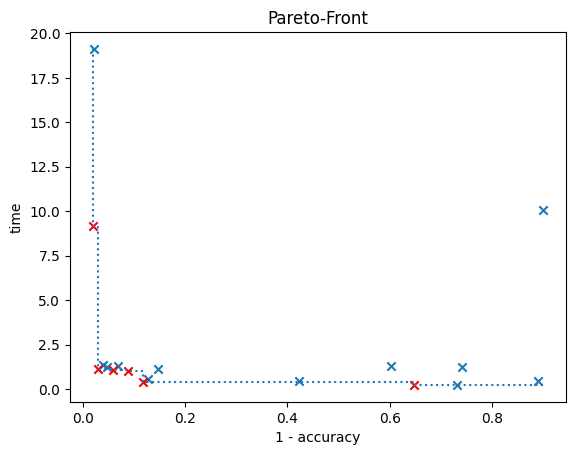

In [7]:
from __future__ import annotations

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    EqualsCondition,
    Float,
    InCondition,
    Integer,
)
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier

from smac import HyperparameterOptimizationFacade as HPOFacade
from smac import Scenario
from smac.facade.abstract_facade import AbstractFacade
from smac.multi_objective.parego import ParEGO


digits = load_digits()


class MLP:
    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()

        n_layer = Integer("n_layer", (1, 5), default=1)
        n_neurons = Integer("n_neurons", (8, 256), log=True, default=10)
        activation = Categorical("activation", ["logistic", "tanh", "relu"], default="tanh")
        solver = Categorical("solver", ["lbfgs", "sgd", "adam"], default="adam")
        batch_size = Integer("batch_size", (30, 300), default=200)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        learning_rate_init = Float("learning_rate_init", (0.0001, 1.0), default=0.001, log=True)

        cs.add_hyperparameters([n_layer, n_neurons, activation, solver, batch_size, learning_rate, learning_rate_init])

        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        use_lr_init = InCondition(child=learning_rate_init, parent=solver, values=["sgd", "adam"])
        use_batch_size = InCondition(child=batch_size, parent=solver, values=["sgd", "adam"])

        # We can also add multiple conditions on hyperparameters at once:
        cs.add_conditions([use_lr, use_batch_size, use_lr_init])

        return cs

    def train(self, config: Configuration, seed: int = 0, budget: int = 10) -> dict[str, float]:
        lr = config["learning_rate"] if config["learning_rate"] else "constant"
        lr_init = config["learning_rate_init"] if config["learning_rate_init"] else 0.001
        batch_size = config["batch_size"] if config["batch_size"] else 200

        start_time = time.time()

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            classifier = MLPClassifier(
                hidden_layer_sizes=[config["n_neurons"]] * config["n_layer"],
                solver=config["solver"],
                batch_size=batch_size,
                activation=config["activation"],
                learning_rate=lr,
                learning_rate_init=lr_init,
                max_iter=int(np.ceil(budget)),
                random_state=seed,
            )

            # Returns the 5-fold cross validation accuracy
            cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)  # to make CV splits consistent
            score = cross_val_score(classifier, digits.data, digits.target, cv=cv, error_score="raise")

        return {
            "1 - accuracy": 1 - np.mean(score),
            "time": time.time() - start_time,
        }


def plot_pareto(smac: AbstractFacade) -> None:
    """Plots configurations from SMAC and highlights the best configurations in a Pareto front."""
    # Get Pareto costs
    _, c = smac.runhistory.get_pareto_front()
    pareto_costs = np.array(c)

    # Sort them a bit
    pareto_costs = pareto_costs[pareto_costs[:, 0].argsort()]

    # Get all other costs from runhistory
    average_costs = []
    for config in smac.runhistory.get_configs():
        # Since we use multiple seeds, we have to average them to get only one cost value pair for each configuration
        average_cost = smac.runhistory.average_cost(config)

        if average_cost not in c:
            average_costs += [average_cost]

    # Let's work with a numpy array
    costs = np.vstack(average_costs)
    costs_x, costs_y = costs[:, 0], costs[:, 1]

    pareto_costs_x, pareto_costs_y = pareto_costs[:, 0], pareto_costs[:, 1]

    plt.scatter(costs_x, costs_y, marker="x")
    plt.scatter(pareto_costs_x, pareto_costs_y, marker="x", c="r")
    plt.step(
        [pareto_costs_x[0]] + pareto_costs_x.tolist() + [np.max(costs_x)],  # We add bounds
        [np.max(costs_y)] + pareto_costs_y.tolist() + [np.min(pareto_costs_y)],  # We add bounds
        where="post",
        linestyle=":",
    )

    plt.title("Pareto-Front")
    plt.xlabel(smac.scenario.objectives[0])
    plt.ylabel(smac.scenario.objectives[1])
    plt.show()


if __name__ == "__main__":
    mlp = MLP()

    # Define our environment variables
    scenario = Scenario(
        mlp.configspace,
        objectives=["1 - accuracy", "time"],
        walltime_limit=60,  # After 60 seconds, we stop the hyperparameter optimization
        n_trials=200,  # Evaluate max 200 different trials
        n_workers=1,
    )

    # We want to run five random configurations before starting the optimization.
    initial_design = HPOFacade.get_initial_design(scenario, n_configs=5)
    multi_objective_algorithm = ParEGO(scenario)

    # Create our SMAC object and pass the scenario and the train method
    smac = HPOFacade(
        scenario,
        mlp.train,
        initial_design=initial_design,
        multi_objective_algorithm=multi_objective_algorithm,
        overwrite=True,
    )

    # Let's optimize
    # Keep in mind: The incumbent is ambiguous here because of ParEGO
    smac.optimize()

    # Get cost of default configuration
    default_cost = smac.validate(mlp.configspace.get_default_configuration())
    print(f"Default costs: {default_cost}\n")

    print("Validated costs from the Pareto front:")
    for i, config in enumerate(smac.runhistory.get_pareto_front()[0]):
        cost = smac.validate(config)
        print(cost)

    # Let's plot a pareto front
    plot_pareto(smac)
